In [2]:
!pip install --upgrade git+https://github.com/titu1994/tfdiffeq.git 

  Cloning https://github.com/titu1994/tfdiffeq.git to /tmp/pip-req-build-tom0nefb
  Running command git clone --filter=blob:none -q https://github.com/titu1994/tfdiffeq.git /tmp/pip-req-build-tom0nefb
  Resolved https://github.com/titu1994/tfdiffeq.git to commit ef646f85cbd0821749a03e7ab51e03e16798fab1
  Preparing metadata (setup.py) ... done
  Created wheel for tfdiffeq: filename=tfdiffeq-0.0.1-py2.py3-none-any.whl size=52343 sha256=e85bcafc0efc10a492aad174203cc06e84fbf3567da891243c22a7e11bc29530
  Stored in directory: /tmp/pip-ephem-wheel-cache-t2ie98b2/wheels/39/f7/18/5249c8ee2e8306b27455aca27c3b64d272570ddb0323eefc04
Successfully built tfdiffeq


In [3]:
import numpy as np
import scipy.io
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import tensorflow as tf
from tfdiffeq import odeint
from tfdiffeq import plot_phase_portrait, plot_vector_field, plot_results

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

2022-03-29 16:11:44.622433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 16:11:44.718387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 16:11:44.719116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [73]:
block_size = 400
train_size = 400
leave_out_for_time_test = block_size - train_size
batch_time = 200
batch_size = 20
niters = 500
freq = 100
scaled = True
zeroflow = True
latent_dim = 2
n_params = 1

data_noise = .001
n_ensemble = 5
n_hidden = 50
anchored = True
n_data = batch_time
W1_var = 1/n_hidden
W_last_var = 1/n_hidden
W1_lambda = data_noise/W1_var
b1_var = W1_var
b1_lambda =  data_noise/b1_var
W_last_lambda = data_noise/W_last_var

device = 'GPU:0' if tf.test.is_gpu_available() else 'cpu:0' # These experiments do not require the GPU. Normally, 'gpu:0' if tf.test.is_gpu_available() else 'cpu:0' should be used.

tf.keras.backend.set_floatx('float64')

2022-03-29 16:30:51.938056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 16:30:51.938653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 16:30:51.939013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 16:30:51.939419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 16:30:51.939765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [7]:
train_mat = scipy.io.loadmat('../input/aedlrom/S_latent_train_20_DLROM.mat')
test_mat = scipy.io.loadmat('../input/aedlrom/S_latent_test_20_DLROM.mat')
train_set = tf.convert_to_tensor(train_mat['S'])
test_set = tf.convert_to_tensor(test_mat['S'])

2022-03-29 16:11:58.639133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 16:11:58.639953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 16:11:58.640571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 16:11:58.641244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 16:11:58.641888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [54]:
train_set = tf.expand_dims(train_set,1)

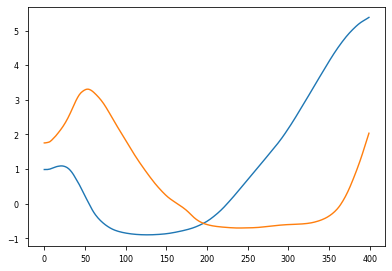

In [8]:
i=2
plt.plot(train_set[i*block_size:(i+1)*block_size,:])

In [58]:
params_ = tf.convert_to_tensor(np.linspace(5e-3,5e-2,20),dtype=tf.float64) 
params_ = tf.expand_dims(params_,1)
params_ = tf.concat([params_,params_],-1)
params_ = tf.expand_dims(params_,1)
params_

<tf.Tensor: shape=(20, 1, 2), dtype=float64, numpy=
array([[[0.005     , 0.005     ]],

       [[0.00736842, 0.00736842]],

       [[0.00973684, 0.00973684]],

       [[0.01210526, 0.01210526]],

       [[0.01447368, 0.01447368]],

       [[0.01684211, 0.01684211]],

       [[0.01921053, 0.01921053]],

       [[0.02157895, 0.02157895]],

       [[0.02394737, 0.02394737]],

       [[0.02631579, 0.02631579]],

       [[0.02868421, 0.02868421]],

       [[0.03105263, 0.03105263]],

       [[0.03342105, 0.03342105]],

       [[0.03578947, 0.03578947]],

       [[0.03815789, 0.03815789]],

       [[0.04052632, 0.04052632]],

       [[0.04289474, 0.04289474]],

       [[0.04526316, 0.04526316]],

       [[0.04763158, 0.04763158]],

       [[0.05      , 0.05      ]]])>

In [84]:
def get_batch():
    # [0,...,batch_time]
    train_set_ = train_set.numpy()
    
    batch_t = tf.convert_to_tensor(np.arange(batch_time),dtype=tf.float64)
        
    # first index of each block [0,400,800,1200,...,7600]
    start_idx = np.arange(0,8000,block_size)
    
    # generate a random t0 for each block
    s = np.random.choice(np.arange(block_size-batch_time-leave_out_for_time_test), batch_size, replace=False)
    # shift to match indexes 
    s = start_idx + s
    
    # select u0 + params
    batch_u0_ = tf.convert_to_tensor(train_set_[s,:,:])
    batch_u0_param = tf.expand_dims(tf.concat([batch_u0_,params_],1),1)
    # select parameters
    
    # u(0),..., u(batch_time)
    batch_u = tf.stack([train_set_[s+i,:,:] for i in range(batch_time)])

    return batch_u0_param, batch_u, batch_t, s

In [85]:
batch_u0_param, batch_u, batch_t, s = get_batch()
batch_u0_param

<tf.Tensor: shape=(20, 1, 2, 2), dtype=float64, numpy=
array([[[[-0.83364916,  3.05178714],
         [ 0.005     ,  0.005     ]]],


       [[[-0.92445791,  1.46374846],
         [ 0.00736842,  0.00736842]]],


       [[[-0.89712667,  1.0263567 ],
         [ 0.00973684,  0.00973684]]],


       [[[-0.57457328,  2.63322806],
         [ 0.01210526,  0.01210526]]],


       [[[ 0.31242448,  2.87608743],
         [ 0.01447368,  0.01447368]]],


       [[[-0.59853518,  2.2465713 ],
         [ 0.01684211,  0.01684211]]],


       [[[-0.75469047,  0.28173056],
         [ 0.01921053,  0.01921053]]],


       [[[-0.60167116,  0.01760273],
         [ 0.02157895,  0.02157895]]],


       [[[-0.76118016,  0.80009168],
         [ 0.02394737,  0.02394737]]],


       [[[-0.74005777,  0.63014972],
         [ 0.02631579,  0.02631579]]],


       [[[-0.30131692,  2.27381063],
         [ 0.02868421,  0.02868421]]],


       [[[-0.70796263,  1.05152714],
         [ 0.03105263,  0.03105263]]],


       [[

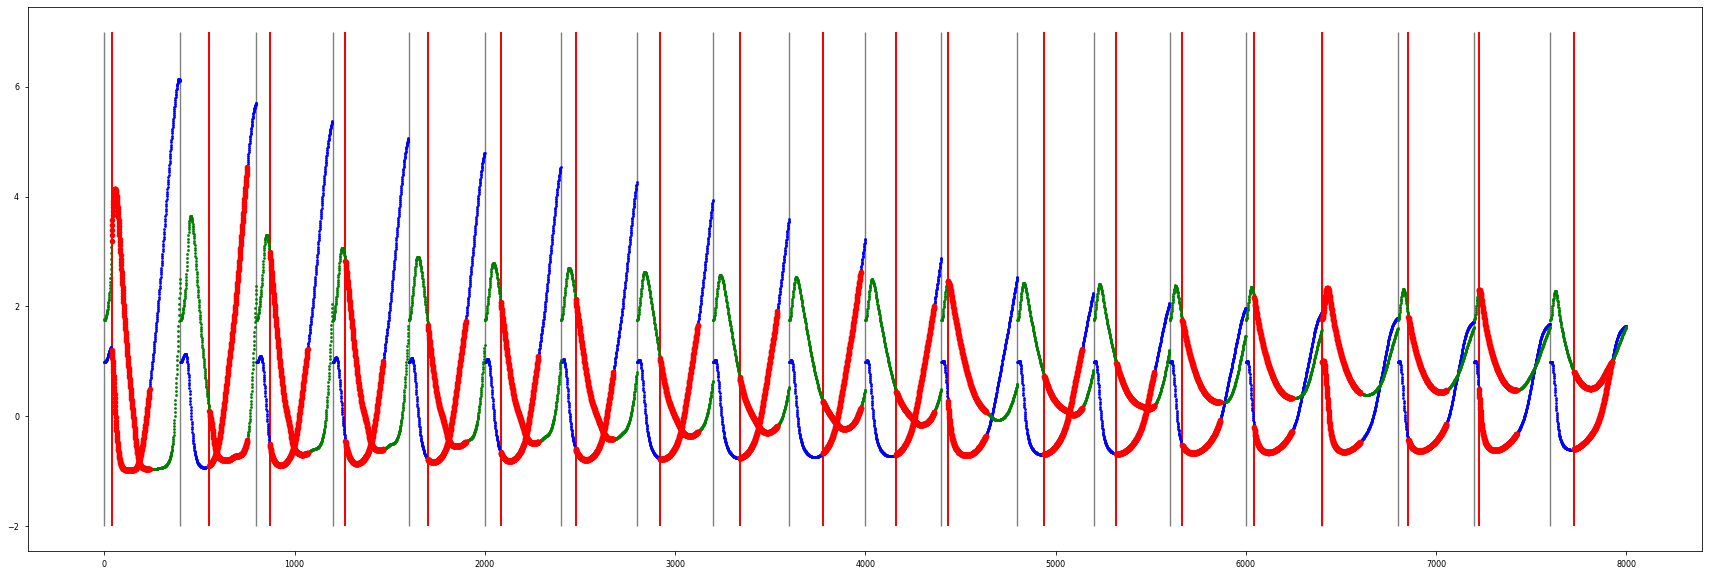

In [76]:
# VISUAL CHECK OF BATCHED DATA

batch_u0_param, batch_u, batch_t, s = get_batch()

plt.figure(figsize=(30,10))
plt.vlines(np.arange(0,8000,400),-2,7,color='gray')
plt.vlines(s,-2,7,color='red',linewidth=2)
plt.plot(train_set[:,:,0],'.b')
plt.plot(train_set[:,:,1],'.g')
for jj in range(batch_size):
    plt.plot(s[jj]+batch_t,batch_u[:,jj,:,0],'or')
    plt.plot(s[jj]+batch_t,batch_u[:,jj,:,1],'or')

In [146]:
class ODEnet(tf.keras.Model):

    def __init__(self, **kwargs):
        super(ODEnet, self).__init__(**kwargs)
        
        self.conv_1 = tf.keras.layers.Conv2D(filters=1, kernel_size=1,strides=(1,1))
        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(n_hidden, activation='tanh')
        self.dense_2 = tf.keras.layers.Dense(latent_dim)

    def call(self, t, u):
        #print(u.shape)
        o1 = self.conv_1(u)
        #print(o1.shape)
        o2 = self.flatten(o1)
        #print(o2.shape)
        o3 = self.dense_1(o2)
        #print(o3.shape)
        o4 = tf.expand_dims(self.dense_2(o3),1)
        #print(o4.shape)
        o5 = tf.expand_dims(tf.concat([o4,tf.zeros_like(o4)],1),1)
        #print(o5.shape)
        return o5

In [147]:
func = ODEnet()

In [156]:
# just a dimensions check

batch_u0_param, batch_u, batch_t, s = get_batch()
test_out = func(0,batch_u0_param)
test_out[:,:,0,:].shape
test_out_int =  odeint(func, batch_u0_param, batch_t)
test_out_int[:,:,:,0,:].shape, batch_u.shape

(TensorShape([200, 20, 1, 2]), TensorShape([200, 20, 1, 2]))

In [162]:
with tf.device(device):

    func = ODEnet()
    train_loss = []
    lr = 1e-3
    optimizer = tf.keras.optimizers.Adam(lr)

    for itr in range(1, niters + 1):
        start_itr = time.time()
        with tf.GradientTape() as tape:
            batch_u0_param, batch_u, batch_t, _ = get_batch()
            pred_u = odeint(func, batch_u0_param, batch_t)
            loss = tf.reduce_mean(tf.abs(pred_u[:,:,:,0,:] - batch_u))
            train_loss.append(loss.numpy())
        grads = tape.gradient(loss, func.variables)
        grad_vars = zip(grads, func.variables)

        optimizer.apply_gradients(grad_vars)
        clear_output(wait=True)
        itr_time = time.time()-start_itr
        display('itr: '+str(itr) + '  loss: ' + str(loss.numpy()) + '   iteration time: '+str(itr_time))
        if itr % 100 == 0:
            #pred_u = odeint(func, true_u0_param, t)
            #tot_loss = tf.reduce_mean(tf.abs(pred_u - true_u_param))
            print('itr: ', itr, '\tloss: ', loss.numpy(), '\titeration time: ', itr_time)



'itr: 1000  loss: 0.18358119591783725   iteration time: 1.5246334075927734'

itr:  1000 	loss:  0.18358119591783725 	iteration time:  1.5246334075927734


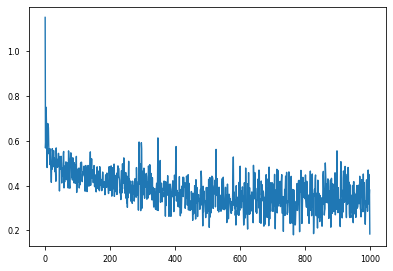

In [163]:
plt.plot(train_loss)

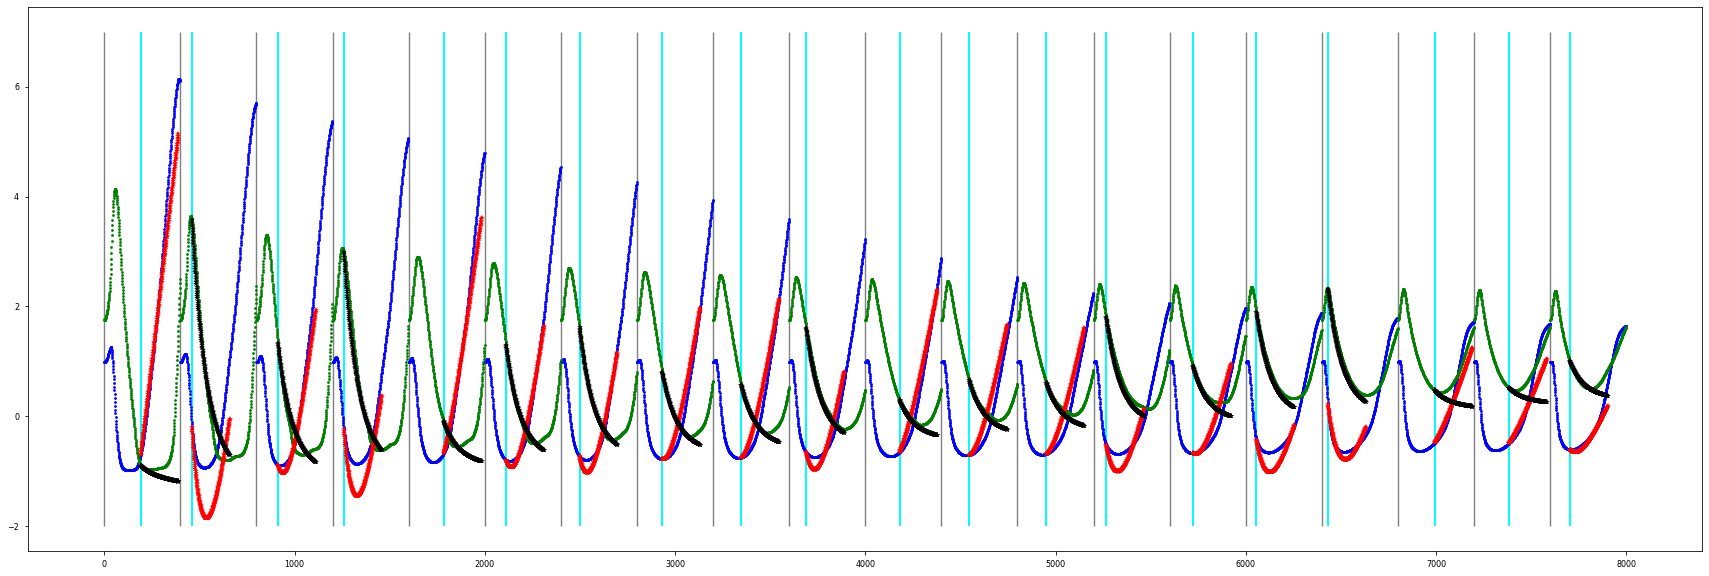

In [171]:
batch_u0_param, batch_u, batch_t, s = get_batch()
pred_u = odeint(func, batch_u0_param, batch_t)

plt.figure(figsize=(30,10))
plt.vlines(np.arange(0,8000,400),-2,7,color='gray')
plt.vlines(s,-2,7,color='cyan',linewidth=2)
plt.plot(train_set[:,:,0],'.b')
plt.plot(train_set[:,:,1],'.g')
for jj in range(batch_size):
    #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,0],'or')
    #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,1],'or')
    plt.plot(s[jj]+batch_t,pred_u[:,jj,:,0,0],'*r')
    plt.plot(s[jj]+batch_t,pred_u[:,jj,:,0,1],'*k')

In [177]:
# FINE

niters_fine = 250
with tf.device(device):

    train_loss = []
    lr = 1e-4
    optimizer = tf.keras.optimizers.RMSprop(lr)

    for itr in range(1, niters_fine + 1):
        start_itr = time.time()
        with tf.GradientTape() as tape:
            batch_u0_param, batch_u, batch_t, _ = get_batch()
            pred_u = odeint(func, batch_u0_param, batch_t)
            loss = tf.reduce_mean(tf.abs(pred_u[:,:,:,0,:] - batch_u))
            train_loss.append(loss.numpy())
        grads = tape.gradient(loss, func.variables)
        grad_vars = zip(grads, func.variables)

        optimizer.apply_gradients(grad_vars)
        clear_output(wait=True)
        itr_time = time.time()-start_itr
        display('itr: '+str(itr) + '  loss: ' + str(loss.numpy()) + '   iteration time: '+str(itr_time))
        if itr % 100 == 0:
            #pred_u = odeint(func, true_u0_param, t)
            #tot_loss = tf.reduce_mean(tf.abs(pred_u - true_u_param))
            print('itr: ', itr, '\tloss: ', loss.numpy(), '\titeration time: ', itr_time)



'itr: 250  loss: 0.36918489716550495   iteration time: 1.373126745223999'

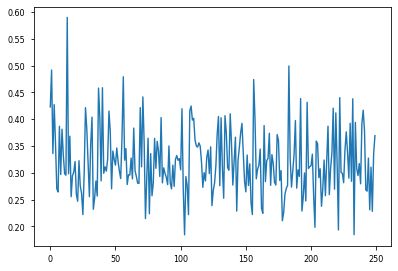

In [178]:
plt.plot(train_loss)

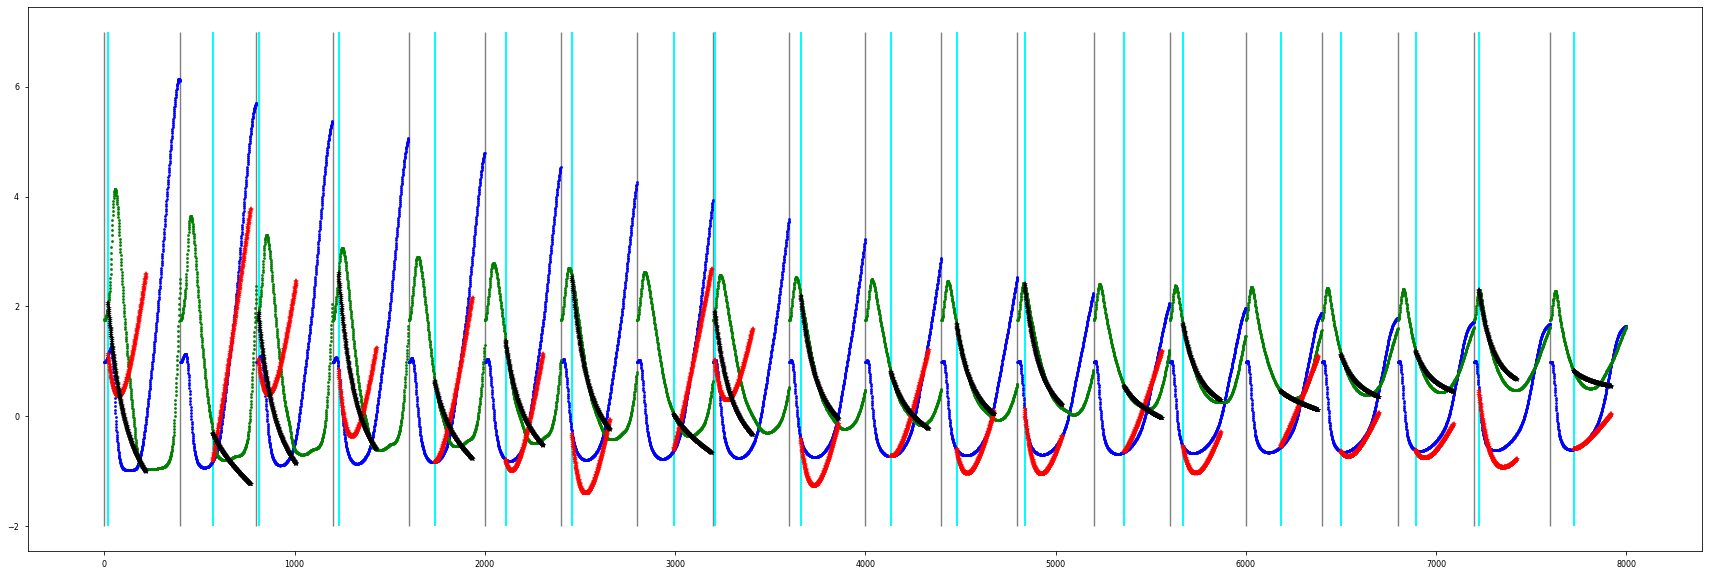

In [189]:
batch_u0_param, batch_u, batch_t, s = get_batch()
pred_u = odeint(func, batch_u0_param, batch_t)

plt.figure(figsize=(30,10))
plt.vlines(np.arange(0,8000,400),-2,7,color='gray')
plt.vlines(s,-2,7,color='cyan',linewidth=2)
plt.plot(train_set[:,:,0],'.b')
plt.plot(train_set[:,:,1],'.g')
for jj in range(batch_size):
    #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,0],'or')
    #plt.plot(s[jj]+batch_t,batch_u[:,jj,:,1],'or')
    plt.plot(s[jj]+batch_t,pred_u[:,jj,:,0,0],'*r')
    plt.plot(s[jj]+batch_t,pred_u[:,jj,:,0,1],'*k')

In [191]:
func.save('odenet')

2022-03-29 18:18:13.639720: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
